# **Nhiệm vụ 5 – Pivot Table + Stack/Unstack**

*Mục tiêu: rèn luyện khả năng chuyển đổi cấu trúc dữ liệu và phân tích theo nhiều chiều*

In [137]:
# import pandas
import pandas as pd

# Read csv
df_teams = pd.read_csv(f'./data_clean/team_info_clean.csv')
df_players = pd.read_csv(f'./data_clean/player_stats_clean.csv')
df_matches = pd.read_csv(f'./data_clean/match_results_clean.csv', parse_dates=['match_date'])

**1. Pivot thể hiện SỐ BÀN THẮNG TRUNG BÌNH THEO ĐỘI × VỊ TRÍ CẦU THỦ**

In [138]:
# Hợp nhất df_players với df_teams để lấy tên đội
df_players_merged = pd.merge(df_players, df_teams[['team_id', 'team_name']], on='team_id', how='left')

# Tạo Pivot Table 
pivot_avg_goals = pd.pivot_table(
    df_players_merged,
    values='goals',
    index='team_name',        # Hàng: Đội bóng
    columns='position',       # Cột: Vị trí cầu thủ
    aggfunc='mean',           # Giá trị: Trung bình số bàn thắng (goals)
    fill_value=0,             # Thay thế NaN bằng 0
    margins=True              # Thêm tổng cộng (All)
)
pivot_avg_goals = pivot_avg_goals.round(2)
pivot_avg_goals

position,DF,FW,GK,MF,All
team_name,,,,,
Clb Binh Duong,1.33,1.33,3.00,2.43,2.08
Clb Ha Noi,4.00,4.40,3.50,3.60,3.79
Clb Hai Phong,2.57,3.00,3.00,2.83,2.83
Clb Thanh Pho Hcm,2.44,2.25,3.62,0.50,2.65
All,2.26,2.70,3.32,2.65,2.77


**2. Pivot thể hiện tổng số bàn thắng ghi được trong các trận đấu theo tháng × đội bóng**

In [139]:
# 1. Trích xuất tháng
df_matches['month'] = df_matches['match_date'].dt.month

# Copy df_matches
df_matches2 = df_matches.copy()

# 2. Unpivot dữ liệu để có tổng bàn thắng theo team_id và tháng
# Tạo DataFrame cho đội nhà
home_goals = df_matches2[['month', 'home_team_id', 'home_goals']].rename(
    columns={'home_team_id': 'team_id', 'home_goals': 'goals'}
)
# Tạo DataFrame cho đội khách
away_goals = df_matches2[['month', 'away_team_id', 'away_goals']].rename(
    columns={'away_team_id': 'team_id', 'away_goals': 'goals'}
)

# Gộp cả hai DataFrame
goals_melted = pd.concat([home_goals, away_goals])

# 3. Tạo pivot table
pivot_goals_by_month_team = goals_melted.pivot_table(
    index='month',
    columns='team_id',
    values='goals',
    aggfunc='sum',
    fill_value=0
)

pivot_goals_by_month_team.index.name = 'Month'
pivot_goals_by_month_team.columns.name = 'Team ID'
print("Tổng số bàn thắng theo Tháng và Đội bóng")
pivot_goals_by_month_team

Tổng số bàn thắng theo Tháng và Đội bóng


Team ID,T01,T02,T03,T04,T05,T06,T07,T08
Month,,,,,,,,
1,2,2,9,4,6,2,7,4
2,6,4,1,5,1,2,1,0
3,5,7,9,4,5,3,7,4
4,9,8,1,9,3,0,14,3
5,0,2,4,2,0,10,4,7
6,6,11,3,7,16,10,7,8


**3. Thực hiện stack/unstack trên pivot để luyện MultiIndex**

In [140]:
# 1. Stack: Chuyển cột (team_id) thành index cấp mới
goals_stacked = pivot_goals_by_month_team.stack()

print("1. Kết quả Stack: Series với MultiIndex (Month, Team ID)")
print("Dữ liệu chuyển từ định dạng 'rộng' sang 'dài'")
goals_stacked.head(8)

1. Kết quả Stack: Series với MultiIndex (Month, Team ID)
Dữ liệu chuyển từ định dạng 'rộng' sang 'dài'


Month  Team ID
1      T01        2
       T02        2
       T03        9
       T04        4
       T05        6
       T06        2
       T07        7
       T08        4
dtype: int64

In [141]:
# 2. Unstack (cấp trong cùng): Đảo ngược thao tác stack (unstack level 1 - Team ID)
goals_unstacked_level_1 = goals_stacked.unstack(level=1)

print("2. Kết quả Unstack(level=1): Quay về Pivot Gốc")
print("*  Unstack level 1 - Team ID, đưa Team ID từ index trở lại columns")
goals_unstacked_level_1

2. Kết quả Unstack(level=1): Quay về Pivot Gốc
*  Unstack level 1 - Team ID, đưa Team ID từ index trở lại columns


Team ID,T01,T02,T03,T04,T05,T06,T07,T08
Month,,,,,,,,
1,2,2,9,4,6,2,7,4
2,6,4,1,5,1,2,1,0
3,5,7,9,4,5,3,7,4
4,9,8,1,9,3,0,14,3
5,0,2,4,2,0,10,4,7
6,6,11,3,7,16,10,7,8


In [142]:
# 3. Unstack (cấp ngoài cùng): Chuyển index cấp ngoài (Month) thành columns
goals_unstacked_level_0 = goals_stacked.unstack(level=0)

print("3. Kết quả Unstack(level=0): Pivot Table Đảo ngược (Đội bóng x Tháng)")
print("*  Unstack level 0 - Month, đưa Month từ index trở lại columns")
goals_unstacked_level_0

3. Kết quả Unstack(level=0): Pivot Table Đảo ngược (Đội bóng x Tháng)
*  Unstack level 0 - Month, đưa Month từ index trở lại columns


Month,1,2,3,4,5,6
Team ID,,,,,,
T01,2,6,5,9,0,6
T02,2,4,7,8,2,11
T03,9,1,9,1,4,3
T04,4,5,4,9,2,7
T05,6,1,5,3,0,16
T06,2,2,3,0,10,10
T07,7,1,7,14,4,7
T08,4,0,4,3,7,8


**5. Đội bóng có hàng công mạnh nhất theo vị trí FW, MF**

In [143]:
# 1. Lọc dữ liệu chỉ lấy FW và MF
offensive_players = df_players[df_players['position'].isin(['FW', 'MF'])]

# 2. Tính tổng số bàn thắng theo đội và vị trí
goals_by_team_position = (
    offensive_players.groupby(['team_id', 'position'])['goals']
        .sum().reset_index()
)

# 3. Tạo pivot table
pivot_offensive_strength = goals_by_team_position.pivot_table(
    index='team_id',
    columns='position',
    values='goals',
    aggfunc='sum',
    fill_value=0
)
_total_offensive_goals = 'Total Offensive Goals'
# Thêm cột tổng bàn thắng FW + MF
pivot_offensive_strength[_total_offensive_goals] = (
    pivot_offensive_strength['FW'] + pivot_offensive_strength['MF']
)

# 4. Sắp xếp để tìm đội mạnh nhất
pivot_offensive_strength = pivot_offensive_strength.sort_values(
    by=_total_offensive_goals,
    ascending=False
)
pivot_offensive_strength

position,FW,MF,Total Offensive Goals
team_id,,,
T03,18,13,31
T04,6,12,18
T07,7,9,16
T02,9,5,14
T08,1,8,9
T06,4,5,9
T01,4,1,5
T05,5,0,5


In [144]:
# 5. Gắn tên đội bóng
pivot_offensive_strength = pivot_offensive_strength.merge(
    df_teams[['team_id', 'team_name']],
    on='team_id',
    how='left'
).set_index('team_name')

# Xóa cột team_id (trùng lặp)
pivot_offensive_strength = pivot_offensive_strength[['FW', 'MF', _total_offensive_goals]]

pivot_offensive_strength.index.name = 'Team Name'
print(" Đánh giá Sức mạnh Hàng công (FW & MF) theo Đội bóng")
print(pivot_offensive_strength)

 Đánh giá Sức mạnh Hàng công (FW & MF) theo Đội bóng
                   FW  MF  Total Offensive Goals
Team Name                                       
Clb Ha Noi         18  13                     31
Clb Hai Phong       6  12                     18
Clb Binh Duong      7   9                     16
Clb Hai Phong       9   5                     14
Clb Binh Duong      1   8                      9
Clb Ha Noi          4   5                      9
Clb Thanh Pho Hcm   4   1                      5
Clb Thanh Pho Hcm   5   0                      5


In [145]:
# Nhận xét
best_offensive_team = pivot_offensive_strength.iloc[0].name
print('Đội tuyển có hàng công tốt nhất:', best_offensive_team)

best_fw_team = pivot_offensive_strength['FW'].idxmax()
print('Đội tuyển vị trí FW công tốt nhất:', best_fw_team)

best_mf_team = pivot_offensive_strength['MF'].idxmax()
print('Đội tuyển vị trí MF công tốt nhất:', best_mf_team)

Đội tuyển có hàng công tốt nhất: Clb Ha Noi
Đội tuyển vị trí FW công tốt nhất: Clb Ha Noi
Đội tuyển vị trí MF công tốt nhất: Clb Ha Noi


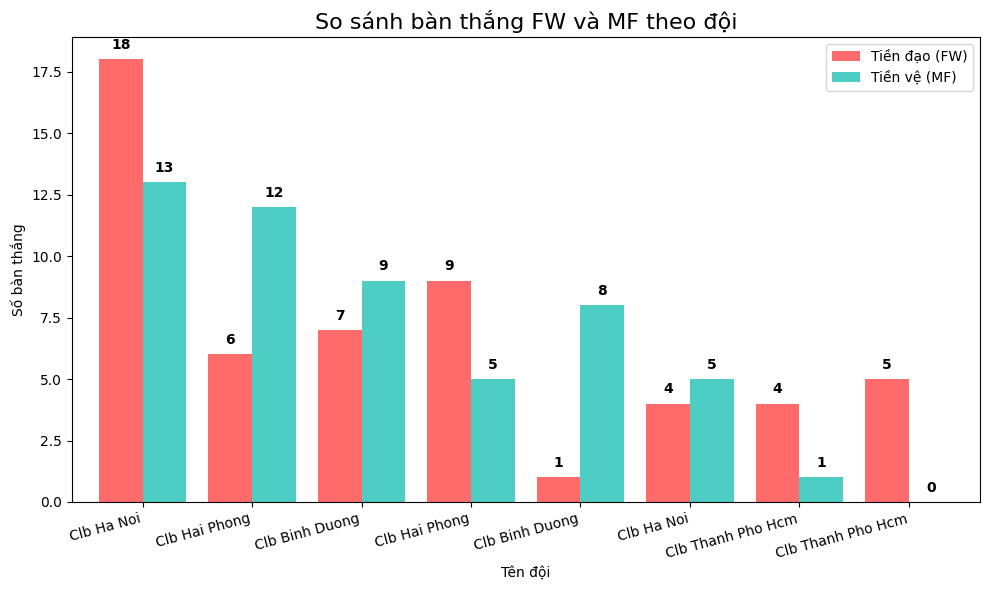

In [156]:
# Biểu đồ dạng thanh so sánh hàng công các đội

import matplotlib.pyplot as plt

ax = pivot_offensive_strength[['FW', 'MF']].plot(
    kind='bar',
    figsize=(10, 6),
    color=['#FF6B6B', '#4ECDC4'],
    width=0.8
)

plt.title('So sánh bàn thắng FW và MF theo đội', fontsize=16)
plt.xlabel('Tên đội')
plt.ylabel('Số bàn thắng')
plt.xticks(rotation=15, ha='right')
plt.legend(['Tiền đạo (FW)', 'Tiền vệ (MF)'])

for i, container in enumerate(ax.containers):
    # ax.containers[0] là các cột FW, ax.containers[1] là các cột MF
    for j, bar in enumerate(container):
        height = bar.get_height()
        # Vị trí text: ngay trên đầu cột, căn giữa
        ax.text(
            bar.get_x() + bar.get_width()/2.,  # tọa độ x
            height + 0.3,                      # tọa độ y (cách đầu cột một chút)
            f'{int(height)}',                  # giá trị hiển thị
            ha='center',
            va='bottom',
            fontweight='bold',
            fontsize=10
        )

plt.tight_layout()
plt.show()